<a href="https://colab.research.google.com/github/Jovania/Projetos-01/blob/master/Regularizacao_L1_e_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Regularização

Neste notebook, vamos demonstrar os dois métodos de Regularização de Regressão mais conhecidos.
* **Método LASSO - ou L1**: Aplica restrição aos coeficientes, *levando alguns a zero, eliminando-os do modelo*.
* **Método Rigge - ou L2**: Aplica uma suavização aos coeficientes, penalizando aqueles que assumem valores muito grandes, *levando-os a tender a zero, porém nunca zerando de fato. Não elimina atributos do modelo*.

### Importando pacotes

In [ ]:
# Basics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Regression and Regularization
from sklearn.linear_model import LinearRegression, Ridge, LassoCV

# Normalização
from sklearn.preprocessing import StandardScaler

# Métricas
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

### Importando o Dataset Houses do Kaggle
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving houses_train.csv to houses_train (2).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['houses_train.csv']))

In [ ]:
# View
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Mostrando as dimensões do dataset
df.shape

(1460, 81)

Veja como é um dataset grande, com 81 variáveis. Certamente vamos precisar de um método de Regularização para que nosso modelo fique mais rápido e menos complexo.

### Limpando os dados para modelagem
Nesta seção, farei uma limpeza bem básica apenas para preparar os dados para modelagem

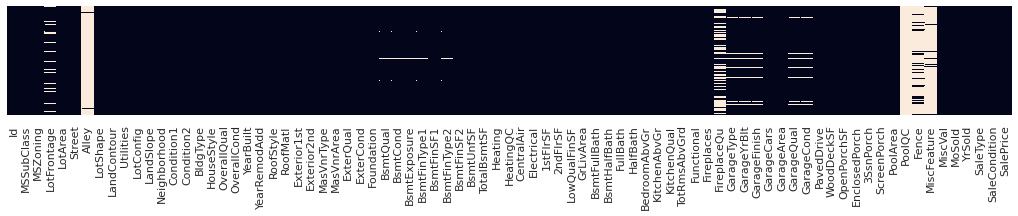

In [ ]:
# Checando valores nulos
plt.figure(figsize=(18,2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False);

A partir do gráfico acima, vemos que a coluna PoolQC contém praticamente todos os valores NaN. Essa coluna só é preenchida quando Pool Area é maior do que zero. Podemos imputar NAs com zero, se quisermos manter a coluna.

O mesmo vale para a coluna FirePlaceQu e MiscFeature e outras com classificação das propriedades da casa.

As colunas Alley e Fence tem valor NA quando não temos corredores dos lados da casa ou cercas. Também podemos preencher com zeros.

Basicamente, podemos preencher todos os NAs com zero, dado que se referem a algum item que não está presente no imóvel e, logo, não tem avaliação.

In [ ]:
# Removendo valores nulos
df.fillna(0, inplace=True)

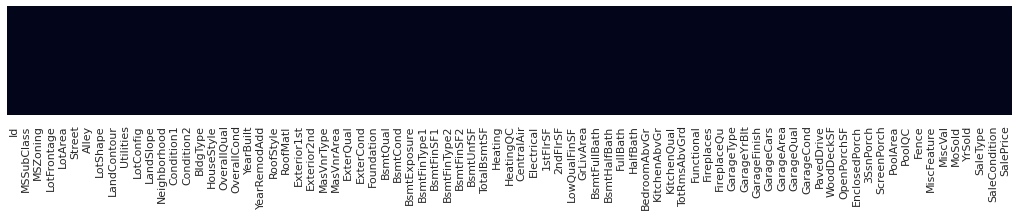

In [ ]:
# Checando transformações
plt.figure(figsize=(18,2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False);

##### Transformando os dados em números para Regressão Linear

In [ ]:
cols = df.select_dtypes(np.number).columns
cols = cols.delete(-1)
df[cols] = StandardScaler().fit_transform(df[cols])

In [ ]:
# Função get_dummies do pandas
df2 = pd.get_dummies(df,drop_first=True)

#### Split de dados

In [ ]:
# Split X e Y
X = df2.drop(['Id','SalePrice'], axis=1)
y = np.log10(df2.SalePrice)

In [ ]:
# Split Treino e teste
Xt, Xteste, yt, yteste = train_test_split(X, y, test_size=0.1, random_state=12)

In [ ]:
def rmse_cv(modelo):
  rmse = np.sqrt(-cross_val_score(modelo,
                                  X,
                                  y,
                                  scoring = 'neg_mean_squared_error',
                                  cv=5))
  return rmse

### Regressão Linear

In [ ]:
# Instancia e fit
modelo_lr = LinearRegression()

# Fit
modelo_lr.fit(Xt,yt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Erro
rmse1 = rmse_cv(modelo_lr)
print(f'O erro do modelo foi de {rmse1.mean()}')

O erro do modelo foi de 410732828.0473703


### Regularização Ridge ou L2

Na Regularização Ridge, temos o parâmetro `alpha`, que é o *lambda*, ou o método de penalização que ajusta os coeficientes. Vamos ver o efeito dele sobre o resultado. 

In [ ]:
 # Loop para testar valores de alpha
 alphas = [0.1, 0.5, 1, 3, 5, 10]
 erro = []
 for a in alphas:
  # Instancia
  lm_ridge = Ridge(alpha=a)
  # Fit
  lm_ridge.fit(Xt,yt)
  # Erro
  rmse2 = rmse_cv(lm_ridge)
  erro.append(rmse2.mean())

In [ ]:
# Erro

print(f'O erro do modelo foi de {round(np.mean(erro),4)}')

O erro do modelo foi de 0.0634


In [ ]:
alphas = [0.1, 0.5, 1, 3, 5, 10, 70]

Abaixo podemos ver o efeito do parâmetro *lambda* sobre os resultados da regressão. Veja como o valor cai até um certo ponto e depois passa a subir.

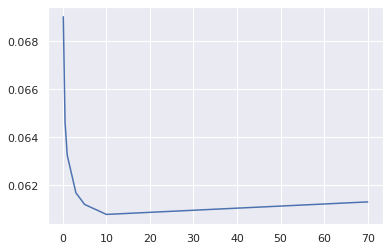

In [ ]:
# Plot do efeito de lambda no modelo
cv_ridge = [rmse_cv(Ridge(alpha=a)).mean() for a in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot();

In [ ]:
# Veja que o método Ridge não chega a zerar quase nenhum coeficiente, mantendo todos eles no modelo.
len(lm_ridge.coef_[lm_ridge.coef_ == 0])

2

### Regularização LASSO ou L1

Na Regularização LASSO, temos o parâmetro `alpha` como método de penalização que zera os coeficientes. Vamos ver o efeito dele sobre o resultado.

In [ ]:
# Instancia e fit
lm_lasso = LassoCV(alphas=[0.000005, 0.001 , 0.1, 0.5, 1]).fit(Xt,yt)


In [ ]:
# Erro
rmse3 = np.sqrt(-cross_val_score(lm_lasso, X, y, scoring = 'neg_mean_squared_error', cv=5))

print(f'O erro do modelo foi de {rmse3.mean()}')

O erro do modelo foi de 0.06305603842227128


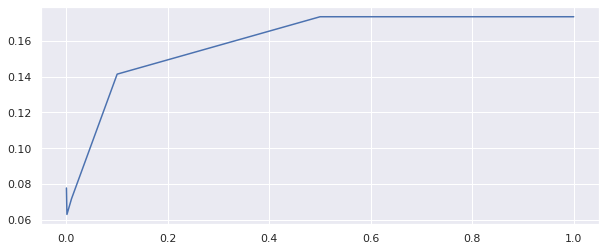

In [ ]:
alphas = [0.000005, 0.001 , 0.01, 0.1, 0.5, 1]
erro_lasso = [rmse_cv( LassoCV(alphas=[a]) ).mean() for a in alphas]
plt.figure(figsize=(10,4))
plt.plot(alphas,erro_lasso);

In [ ]:
# Veja que o método LASSO zerou mais de 200 coeficientes, fazendo uma seleção de atributos.
len(lm_lasso.coef_[lm_lasso.coef_ == 0.00])

206

### Validação

In [ ]:
# Regressão Linear
predlm = modelo_lr.predict(Xteste)

# Ridge
predridge = lm_ridge.predict(Xteste)

# Lasso
predlasso = lm_lasso.predict(Xteste)

In [ ]:
# Performance Dataset
performance = pd.DataFrame({'Valor Y':yteste, 'Regressao': predlm, 'DifReg': yteste-predlm, 'Ridge': predridge, 'DifRidge': yteste-predridge, 'Lasso': predlasso, 'DifLasso': yteste-predlasso})

In [ ]:
pd.DataFrame([{'Erro Regressão': round(performance.DifReg.mean()), 'Erro Ridge':round(10**performance.DifRidge.mean(),3), 'Erro Lasso': round(10** performance.DifLasso.mean(),3)}])

,Erro Regressão,Erro Ridge,Erro Lasso
0,977027,1.011,1.012


## FIM